# CONV3d Experiments

Let's see how the conv3d works.

## Creating a segmentation model

We use conv3d to create a segmentation model. We will use initially a crossconv3d and then a scatteredone.

We will use the bone and tooth synthetic data.

The goal will be that model can separate the bone from the tooth.

In [1]:

from tensorflow import Tensor, split
from tensorflow.keras.layers import (
    Input, Reshape, Lambda, Dense, Dropout,
    Softmax)
from tensorflow.keras.models import Model

from vconv_layer import CrossConvV2


def make_model(num_conv_layers=2, parallel_conv_per_layer=6, num_units=32,
               weighter_depth=1) -> Model:
    # sequences of 16 points
    inpt = Input((16, 3))

    conv_layers = [CrossConvV2(num_convs=parallel_conv_per_layer, out_feats=num_units,
                               weighter_depth=weighter_depth) for _ in range(num_conv_layers)]

    #conv1_layer = CrossConvV2(num_convs=6)
    #conv2_layer = CrossConvV2(num_convs=6)
    #conv3_layer = CrossConvV2(num_convs=6)

    def split_feat(x: Tensor) -> Tensor:
        return split(x, [3, -1], axis=-1)[1]

    feat_layer = Lambda(split_feat)
    reshape_layer = Reshape(target_shape=(1, -1))
    dropout_layer = Dropout(rate=0.10)
    dense_layer = Dense(units=2)
    softmax_layer = Softmax()

    x = inpt

    for conv in conv_layers:
        x = conv(x)

    #x = conv1_layer(x)
    #x = conv2_layer(x)
    #x = conv3_layer(x)
    x = feat_layer(x)
    x = dropout_layer(x)
    x = dense_layer(x)
    x = softmax_layer(x)

    outpt = x

    return Model(inpt, outpt)

In [2]:
model = make_model(num_conv_layers=2, parallel_conv_per_layer=16, num_units=32, weighter_depth=2)
model.summary()

2024-02-07 11:39:39.342017: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-02-07 11:39:39.342052: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-02-07 11:39:39.342059: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-02-07 11:39:39.342105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-07 11:39:39.342127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 3)]           0         
                                                                 
 cross_conv_v2 (CrossConvV2  (None, 16, 515)           30720     
 )                                                               
                                                                 
 cross_conv_v2_1 (CrossConv  (None, 16, 515)           6833152   
 V2)                                                             
                                                                 
 lambda (Lambda)             (None, 16, 512)           0         
                                                                 
 dropout_64 (Dropout)        (None, 16, 512)           0         
                                                                 
 dense_64 (Dense)            (None, 16, 2)             1026  

### Smoke test

Let's check if it works

In [3]:
from tensorflow import convert_to_tensor

inp = convert_to_tensor([
    [
        [i * j, i * j, i * j] for i in range(16)
    ] for j in range(10)
])
display(inp)
out = model(inp)
display(out)

<tf.Tensor: shape=(10, 16, 3), dtype=int32, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  1,   1,   1],
        [  2,   2,   2],
        [  3,   3,   3],
        [  4,   4,   4],
        [  5,   5,   5],
        [  6,   6,   6],
        [  7,   7,   7],
        [  8,   8,   8],
        [  9,   9,   9],
        [ 10,  10,  10],
        [ 11,  11,  11],
        [ 12,  12,  12],
        [ 13,  13,  13],
        [ 14,  14,  14],
        [ 15,  15,  15]],

       [[  0,   0,   0],
        [  2,   2,   2],
        [  4,   4,   4],
        [  6,   6,   6],
        [  8,   8,   8],
        [ 10,  10,  

<tf.Tensor: shape=(10, 16, 2), dtype=float32, numpy=
array([[[0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ],
        [0.46531576, 0.5346842 ]],

       [[0.4968026 , 0.5031974 ],
        [0.49576882, 0.5042312 ],
        [0.49495924, 0.50504076],
        [0.49425364, 0.5057463 ],
        [0.49369374, 0.5063063 ],
        [0.4933977 , 0.5066023 ],
        [0.4932598 , 0.5067402 ],
        [0.49322137, 0.5067786 ],
        [0.493266  , 0.506734  ],
        [0.49338534, 0.5066147 ],
        [0.49363178, 0.5063682 ],
        [0.4941453 , 0.5058

## Now create some input and output

In [4]:
from typing import Tuple, Iterator
from second_util import ToothFactory, random_rotate_and_traslate
import numpy as np

tooth_factory = ToothFactory()

teeth = tooth_factory.generate_data(count=10000)
teeth_seg = np.array([[1.0, 0.0] * 8 + [0.0, 1.0] * 8] * 10000).reshape((-1, 16, 2))


def generate_samples(num: int = 1024) -> Iterator[Tuple[Tensor, Tensor]]:
    for i in range(num):
        tooth = tooth_factory.generate_data(count=1)[0]
        tooth = np.squeeze(random_rotate_and_traslate(tooth))
        out = np.array([[1.0, 0.0]] * 8 + [[0.0, 1.0]] * 8)
        p = np.random.permutation(16)
        yield tooth[p], out[p]


next(generate_samples())

(array([[  0.4899658 , -10.5667476 ,  -2.62456347],
        [ -1.21952759,  -6.38425252,   6.6707432 ],
        [ 10.57087637,  -1.48147481,   6.63306547],
        [  6.01680805,  -9.52931266,   9.41671677],
        [  1.46069493,   2.30793875,   0.76004719],
        [ -0.04620461,  -3.85142615,   3.25436819],
        [ -8.31911558,   3.7157014 ,  -1.67198465],
        [ 12.28036976,  -5.66396989,  -2.6622412 ],
        [  2.42862272,  -0.06022086,  -4.50302411],
        [  5.04403412,  -2.51890975,  -5.40821477],
        [  0.92172318,  -6.21958576,  -2.00870312],
        [ -9.82601512,  -2.44366349,   0.82233635],
        [ -7.3511878 ,   1.34754179,  -6.93505595],
        [  7.72630144, -13.71180774,   0.1214101 ],
        [ -8.85808734,  -4.8118231 ,  -4.44073496],
        [  3.33454074,   1.66358532,   3.8870919 ]]),
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
    

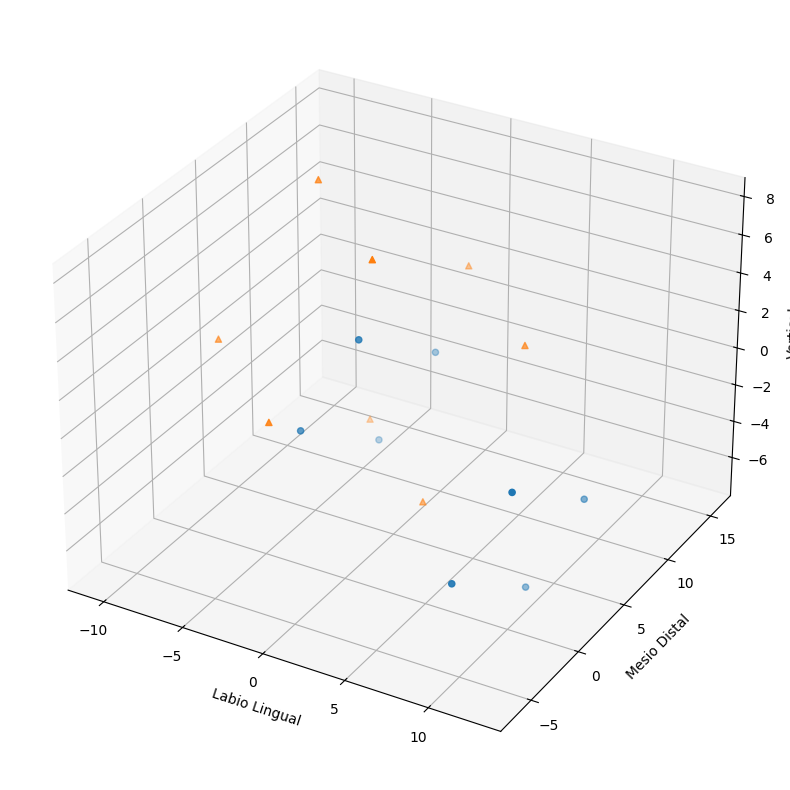

In [5]:
tooth = tooth_factory.generate_data(1)
tooth = np.squeeze(random_rotate_and_traslate(tooth))
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('persp')
ax.set_xlabel('Labio Lingual')
ax.set_zlabel('Vertical')
ax.set_ylabel('Mesio Distal')
ax.scatter(tooth[0:8, 0], tooth[0:8, 2], tooth[0:8, 1], marker='o')
ax.scatter(tooth[8:16, 0], tooth[8:16, 2], tooth[8:16, 1], marker='^')


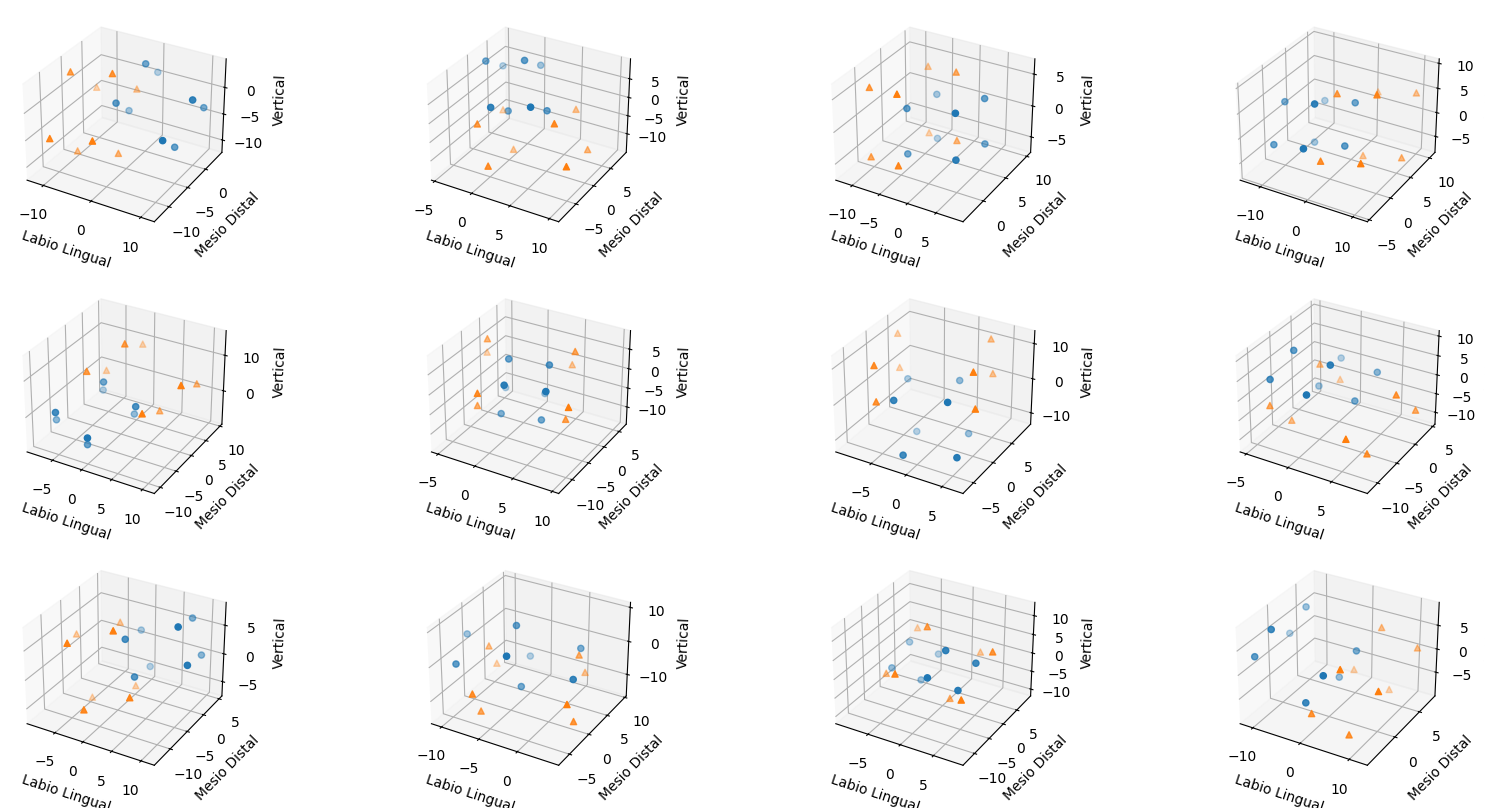

In [6]:
fig = plt.figure(figsize=(20, 10))
i = 0
for tooth, cls in generate_samples(12):
    i += 1
    ax = fig.add_subplot(3, 4, i, projection='3d')
    ax.set_proj_type('persp')
    ax.set_xlabel('Labio Lingual')
    ax.set_zlabel('Vertical')
    ax.set_ylabel('Mesio Distal')
    ax.scatter(tooth[cls[:, 0] == 1, 0], tooth[cls[:, 0] == 1, 2], tooth[cls[:, 0] == 1, 1],
               marker='o')
    ax.scatter(tooth[cls[:, 1] == 1, 0], tooth[cls[:, 1] == 1, 2], tooth[cls[:, 1] == 1, 1],
               marker='^')

## Now train the model

In [7]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

model.compile(
    loss=CategoricalCrossentropy(),
    metrics=CategoricalAccuracy(),
    run_eagerly=True
)

In [8]:
from tensorflow.data import Dataset
from tensorflow import TensorSpec, float64
from tensorflow.data.experimental import assert_cardinality

BATCH_SIZE = 128
TRAIN_LEN = BATCH_SIZE * 1024
TEST_LEN = BATCH_SIZE * 16

data_train = Dataset.from_generator(generate_samples, output_signature=(
    TensorSpec(shape=(16, 3), dtype=float64),
    TensorSpec(shape=(16, 2), dtype=float64)
), args=(TRAIN_LEN,))
data_train = data_train.apply(assert_cardinality(TRAIN_LEN))
data_test = Dataset.from_generator(generate_samples, output_signature=(
    TensorSpec(shape=(16, 3), dtype=float64),
    TensorSpec(shape=(16, 2), dtype=float64)
), args=(TEST_LEN,))
data_test = data_test.apply(assert_cardinality(TEST_LEN))

data_train.cardinality().numpy()


131072

In [9]:
steps_per_epoch = len(data_train.batch(BATCH_SIZE))
validation_steps = len(data_test.batch(BATCH_SIZE))

In [10]:
res = model.fit(data_train.batch(BATCH_SIZE * 2), validation_data=data_test.batch(BATCH_SIZE * 2),
                epochs=10)

Epoch 1/10
512/512 [==============================] - 881s 2s/step - loss: 0.5199 - categorical_accuracy: 0.7199 - val_loss: 0.3158 - val_categorical_accuracy: 0.8393
Epoch 2/10
512/512 [==============================] - 849s 2s/step - loss: 0.3323 - categorical_accuracy: 0.8520 - val_loss: 0.2421 - val_categorical_accuracy: 0.9081
Epoch 3/10
512/512 [==============================] - 825s 2s/step - loss: 0.2622 - categorical_accuracy: 0.8835 - val_loss: 0.1748 - val_categorical_accuracy: 0.9348
Epoch 4/10
512/512 [==============================] - 833s 2s/step - loss: 0.2035 - categorical_accuracy: 0.9125 - val_loss: 0.2606 - val_categorical_accuracy: 0.8909
Epoch 5/10
512/512 [==============================] - 823s 2s/step - loss: 0.1479 - categorical_accuracy: 0.9405 - val_loss: 0.1045 - val_categorical_accuracy: 0.9619
Epoch 6/10
512/512 [==============================] - 822s 2s/step - loss: 0.1051 - categorical_accuracy: 0.9609 - val_loss: 0.0397 - val_categorical_accuracy: 0.987

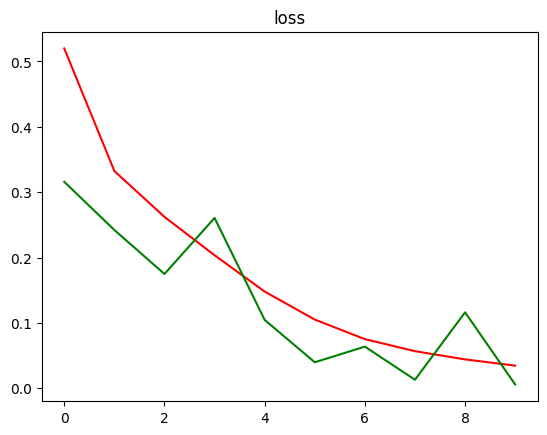

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.title("loss")
plt.plot(res.history['loss'], color="red")
plt.plot(res.history['val_loss'], color="green")
plt.show()

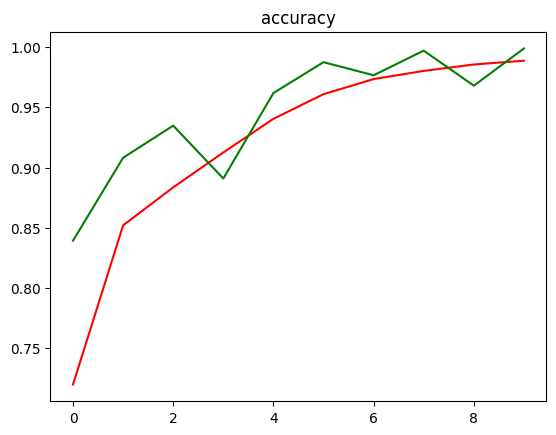

In [12]:
plt.title("accuracy")
plt.plot(res.history['categorical_accuracy'], color="red")
plt.plot(res.history['val_categorical_accuracy'], color="green")
plt.show()

In [13]:
np.argmax(model(convert_to_tensor(teeth[0:10])).numpy(), axis=-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]])

In [14]:
res.history['categorical_accuracy']

[0.7198567390441895,
 0.8520207405090332,
 0.8835453987121582,
 0.9125018119812012,
 0.940462589263916,
 0.9609155654907227,
 0.9734487533569336,
 0.9802498817443848,
 0.9855709075927734,
 0.9887270927429199]

In [15]:
model.weights[2].numpy()

array([[ 0.38038447,  0.34581083, -0.11301249, ..., -0.31428286,
         0.13345236, -0.02646864],
       [-0.1689133 , -0.25167757, -0.00209188, ...,  0.02283597,
         0.17215066,  0.23823537],
       [-0.5698815 , -0.20834525, -0.22740133, ...,  0.00937824,
        -0.13291615,  0.36635736],
       ...,
       [-0.01124706,  0.07671952, -0.24743712, ...,  0.3459398 ,
        -0.06015314, -0.0202661 ],
       [ 0.0362301 , -0.28295776,  0.413136  , ...,  0.13294601,
         0.01568635,  0.17400292],
       [-0.3492896 ,  0.36093533, -0.40355676, ...,  0.0809743 ,
        -0.24499054,  0.27088228]], dtype=float32)

In [16]:
from utils import datadir

model.save(datadir("cross_conv_V2_3_layers_big"))

INFO:tensorflow:Assets written to: /Users/vittorio/Projects/Implantmaster.ai/prototype1/data/cross_conv_V2_3_layers/assets


INFO:tensorflow:Assets written to: /Users/vittorio/Projects/Implantmaster.ai/prototype1/data/cross_conv_V2_3_layers/assets
